In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/saved_model.pb
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/keras_metadata.pb
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/assets/vocab.txt
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/variables/variables.index
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/variables/variables.data-00000-of-00001
/kaggle/input/gnews-swivel/tensorflow2/tf2-preview-20dim/1/saved_model.pb
/kaggle/input/gnews-swivel/tensorflow2/tf2-preview-20dim/1/assets/tokens.txt
/kaggle/input/gnews-swivel/tensorflow2/tf2-preview-20dim/1/variables/variables.index
/kaggle/input/gnews-swivel/tensorflow2/tf2-preview-20dim/1/variables/variables.data-00000-of-00001
/kaggle/input/m/keras/bert/keras/bert_base_en_uncased/2/config.json
/kaggle/input/m/keras/bert/keras/bert_base_en_uncased/2/tokeniz

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier 
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Conv1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras_nlp
from transformers import AutoTokenizer, TFBertForSequenceClassification, BertTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.tokenize import word_tokenize
import re
import nltk
nltk.download('punkt')  


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)



2025-05-26 11:23:30.961041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748258611.195920      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748258611.268210      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [4]:
train = train.drop(['id', 'location', 'keyword'], axis=1)

In [5]:
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [6]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# EDA

In [7]:
train.info()
print('-------------------------------------------------')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [8]:
def missing_percentage(df):
    print((df.isna().sum().sort_values(ascending=False)/df.shape[0])*100) 


missing_percentage(train)
print('-----------------------------------------')
missing_percentage(test)

text      0.0
target    0.0
dtype: float64
-----------------------------------------
location    33.864542
keyword      0.796813
id           0.000000
text         0.000000
dtype: float64


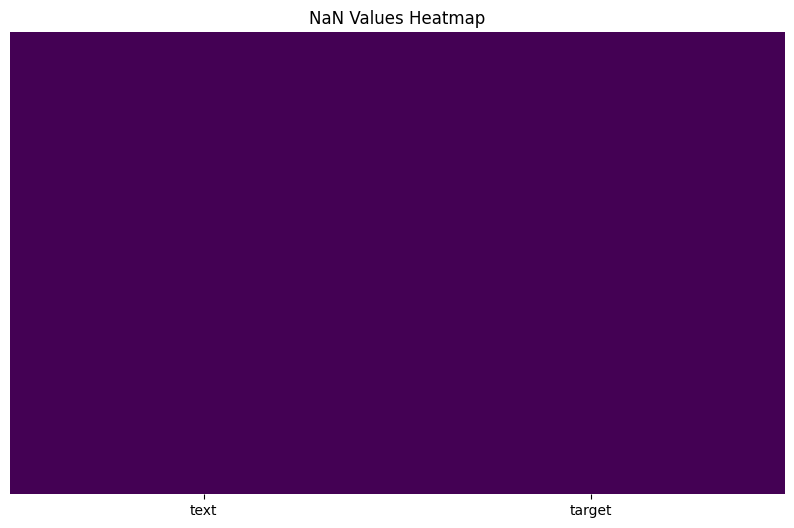

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(train.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("NaN Values Heatmap")
plt.show()

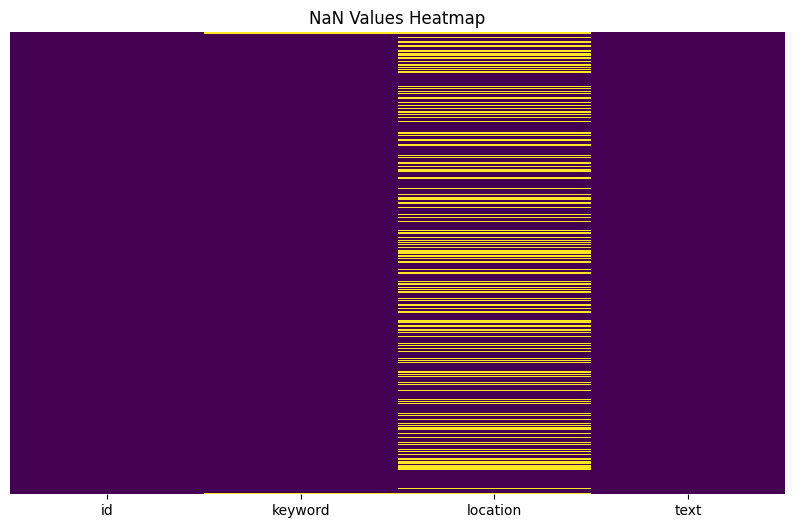

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(test.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("NaN Values Heatmap")
plt.show()

In [11]:
train

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...
7608,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


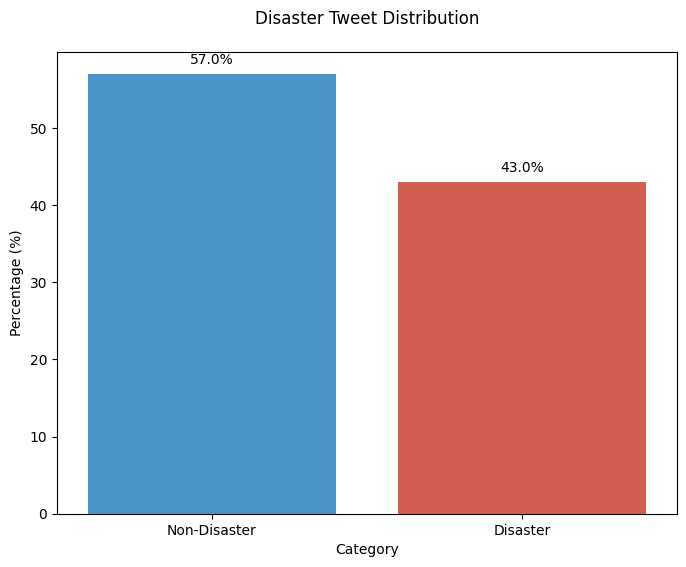

In [12]:
# Calculate percentages
value_counts = train['target'].value_counts(normalize=True) * 100

# Create figure
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=value_counts.index, 
                 y=value_counts.values, 
                 palette=['#3498db', '#e74c3c'])

# Add percentages on top
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# Customize
plt.title('Disaster Tweet Distribution', pad=20)
plt.xlabel('Category')
plt.ylabel('Percentage (%)')
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])
#plt.ylim(0, 100)
plt.show()

# Data prep

In [13]:
print(train.sample(n=20).to_string(index=False))

                                                                                                                                        text  target
                                   Be annihilated for status education mba on behalf of a on easy street careen: eOvm http://t.co/e0pI0c54FF       0
                                                                 70th anniversary of Hiroshima atomic bombing marked  http://t.co/1mGvd4x5Oe       1
      Terrifying POV footage captures violent landing from inside a passenger jet during a storm in Amsterdam http://t.co/NqXQYI70W4 #travel       1
      @montetjwitter11 @nolesfan05 @NutsAndBoltsSP I say concern but not panic. Too many games left. And some games left against each other.       0
                                       What tropical storm? #guillermo by hawaiianpaddlesports http://t.co/LgPgAjgomY http://t.co/FKd1mBTB68       1
                                     Photo: Sketch I did based on the A Taste of Armageddon episode of #st

## data processing

In [14]:
stemmer = SnowballStemmer('english')

def text_preprocess_with_stemming(text):
    """
    Enhanced text preprocessing with stemming for tweet classification.
    Handles URLs, hashtags, punctuation, numbers, and applies stemming.
    
    Args:
        text (str): Raw tweet text
        
    Returns:
        str: Processed and stemmed text
    """
    # Step 1: Basic cleaning
    text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r"#(\w+)", r"\1", text)  # Remove hashtag symbol but keep text
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation (keep underscores)
    text = re.sub(r'\n', ' ', text)  # Replace newlines with spaces
    text = re.sub(r'\d+', '', text)  # Remove numbers
    
    # Step 2: Case normalization
    text = text.lower().strip()
    
    # Step 3: Tokenization and stemming
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(stemmed_tokens)


In [15]:
train_df = train.copy()

train_df['clean_text'] = train_df['text'].apply(text_preprocess_with_stemming)

In [16]:
print(train_df[['clean_text', 'text']].sample(n=20))

                                                                                                                       clean_text  \
7364                                                                                          look outsid at the windstorm niiiic   
1478                                                          review pixelsmovi not a catastroph nor a funni movi our review here   
6106  if there a chanc will get a gander of the sink ship that is tna too cant help but appeas my morbid curios destinationimpact   
5351                                                                       cyclist it is pandemonium on the road today drive care   
6551                                                               by the grace of god i surviv the am shift and im not that tire   
4077                          strong thunderstorm mile north of japton move se at mph larg hail and wind gust up to mph poss arwx   
6424                         suicid bomber kill more than a dozen in 

# Model training

In [17]:

#X = train_df.drop(columns=['target'])
X = train_df['clean_text']
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evaluate classification model with key metrics and visualizations
    
    Parameters:
    y_true (array): True labels
    y_pred (array): Predicted labels
    model_name (str): Name for display purposes
    """
    # Calculate metrics
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    # Print metrics
    print(f"╔{'═'*30}╗")
    print(f"║ {model_name.upper():^28} ║")
    print(f"╠{'═'*30}╣")
    print(f"║ {'F1 Score:':<15} {f1:.4f}{'║':>9}")
    print(f"║ {'Precision:':<15} {precision:.4f}{'║':>9}")
    print(f"║ {'Recall:':<15} {recall:.4f}{'║':>9}")
    print(f"╚{'═'*30}╝\n")
    
    # Confusion matrix visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Disaster', 'Disaster'],
                yticklabels=['Non-Disaster', 'Disaster'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {'f1': f1, 'precision': precision, 'recall': recall}

# Usage example:
# y_true = test_df['target']
# y_pred = model.predict(X_test)
# metrics = evaluate_model(y_true, y_pred, "Disaster Tweet Classifier")

## TF IDF

### 1

In [19]:
model = make_pipeline(
    TfidfVectorizer(stop_words='english', max_df= 0.7, max_features= 10000, min_df= 1, ngram_range= (1, 1), norm= 'l2'),  # Text to numbers
    RandomForestClassifier(n_estimators = 500, class_weight='balanced', min_samples_leaf= 2) 
)

# Train (X_train = tweets, y_train = labels)
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.7, max_features=10000,
                                 stop_words='english')),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=2,
                                        n_estimators=500))])

╔══════════════════════════════╗
║       TRAIN DATA TF-IDF      ║
╠══════════════════════════════╣
║ F1 Score:       0.8707        ║
║ Precision:      0.8695        ║
║ Recall:         0.8719        ║
╚══════════════════════════════╝



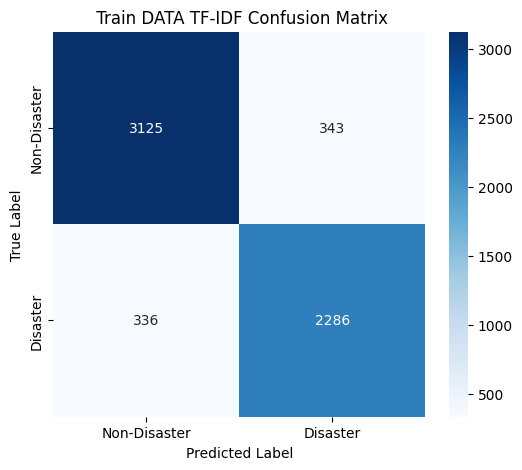

In [20]:
y_train_pred = model.predict(X_train)
metrics = evaluate_model(y_train, y_train_pred, " Train DATA TF-IDF")

╔══════════════════════════════╗
║       TEST DATA TF-IDF       ║
╠══════════════════════════════╣
║ F1 Score:       0.7396        ║
║ Precision:      0.7151        ║
║ Recall:         0.7658        ║
╚══════════════════════════════╝



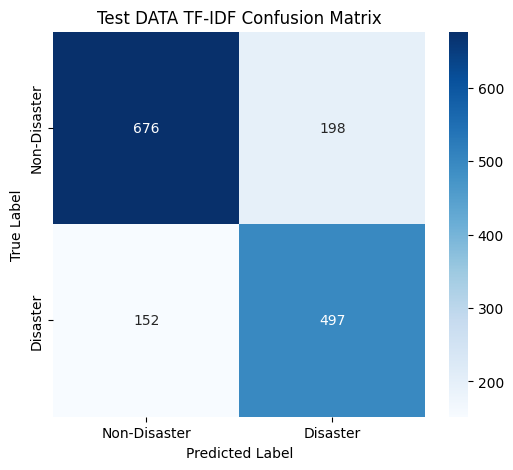

In [21]:
y_pred = model.predict(X_test)
metrics = evaluate_model(y_test, y_pred, "Test DATA TF-IDF")

### Word Embedding


In [22]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['clean_text'])
X_padded = pad_sequences(train_sequences, maxlen=70, padding='post', truncating='post')


y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [23]:
model = Sequential([
    # Input Layer
    Embedding(input_dim=10000, output_dim=128, input_length=30),
    # Convolutional Block (Multiple filter sizes)
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    # Parallel Bidirectional LSTMs
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    # Combined Features
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    # Output Layer
    Dense(1, activation='sigmoid')
])

I0000 00:00:1748258655.437755      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748258655.438438      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [24]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy', AUC(name='auc')]
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=100
)

Epoch 1/50


I0000 00:00:1748258664.415794      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.5925 - auc: 0.5746 - loss: 0.6644 - val_accuracy: 0.7879 - val_auc: 0.8446 - val_loss: 0.4788
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8524 - auc: 0.9019 - loss: 0.3727 - val_accuracy: 0.7800 - val_auc: 0.8462 - val_loss: 0.4649
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9106 - auc: 0.9550 - loss: 0.2517 - val_accuracy: 0.7820 - val_auc: 0.8451 - val_loss: 0.5468
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9457 - auc: 0.9774 - loss: 0.1675 - val_accuracy: 0.7728 - val_auc: 0.8325 - val_loss: 0.6590
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9583 - auc: 0.9858 - loss: 0.1310 - val_accuracy: 0.7715 - val_auc: 0.8308 - val_loss: 0.6606
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9704 - auc: 0.9910 - loss: 0.0964 - val_accuracy: 0.7794 - val_auc: 0.8214 - val_loss: 0.7655
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - acc

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
╔══════════════════════════════╗
║        TEST EMBEDDING        ║
╠══════════════════════════════╣
║ F1 Score:       0.7098        ║
║ Precision:      0.7270        ║
║ Recall:         0.6934        ║
╚══════════════════════════════╝



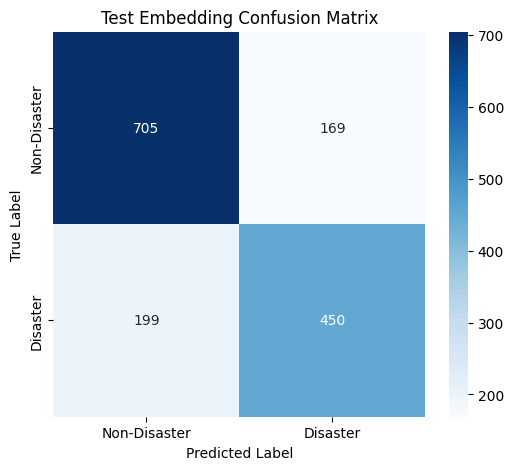

In [25]:
y_pred = model.predict(X_test)
y_pred_thresh = (y_pred > 0.47).astype(int)
metrics = evaluate_model(y_test, y_pred_thresh, "Test Embedding")

## BERT

In [26]:
def text_preprocess(text):
    """Optimal cleaning for BERT while preserving semantic cues"""
    # 1. Remove URLs and user mentions
    text = re.sub(r'http\S+|@\w+', '', text)
    
    # 2. Clean hashtags (keep text, remove #)
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # 3. Standardize apostrophes
    text = re.sub(r'[‘’´`]', "'", text)
    
    return text.strip()

In [27]:
train_df = train.copy()

train_df['clean_text'] = train_df['text'].apply(text_preprocess)

In [28]:

#X = train_df.drop(columns=['target'])
X = train_df['clean_text']
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [30]:
# Initialize preprocessor
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    "bert_base_en_uncased",
    sequence_length=128
)

# Get ALL required BERT inputs (token_ids, segment_ids, padding_mask)
def preprocess_text(text):
    output = preprocessor(text)
    return {
        "token_ids": output["token_ids"],
        "segment_ids": output["segment_ids"],  # ← MISSING IN YOUR CODE
        "padding_mask": output["padding_mask"]
    }

# Preprocess all data
preprocessed = [preprocess_text(t) for t in X_train]

dataset = tf.data.Dataset.from_tensor_slices((
    {
        "token_ids": np.stack([x["token_ids"] for x in preprocessed]),
        "segment_ids": np.stack([x["segment_ids"] for x in preprocessed]),  # ← ADDED
        "padding_mask": np.stack([x["padding_mask"] for x in preprocessed])
    },
    y_train
)).batch(32).prefetch(tf.data.AUTOTUNE)

In [31]:
# Define model inputs (numeric only!)
inputs = {
    "token_ids": tf.keras.Input(shape=(128,), dtype=tf.int32, name="token_ids"),
     "segment_ids": tf.keras.Input(shape=(128,), dtype=tf.int32, name="segment_ids"),
    "padding_mask": tf.keras.Input(shape=(128,), dtype=tf.int32, name="padding_mask")
}

# BERT encoder
encoder = keras_nlp.models.BertBackbone.from_preset("bert_base_en_uncased")
outputs = encoder(inputs)

# Classification head
pooled_output = outputs["pooled_output"]  # [batch_size, 768]

Dence_layer = tf.keras.layers.Dense(64, activation='relu')(pooled_output)


predictions = tf.keras.layers.Dense(1, activation="sigmoid")(Dence_layer)

# Compile
model = tf.keras.Model(inputs=inputs, outputs=predictions)
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [32]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_ids (InputLayer)  │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_backbone             │ [(None, 768), (None,   │    109,482,240 │ padding_mask[0][0],    │
│ (BertBackbone)            │ 128, 768)]             │                │ segment_ids[0][0],     │
│                           │                        │                │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │         49,216 │ bert_backbone[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             65 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 109,531,521 (417.83 MB)

 Trainable params: 109,531,521 (417.83 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# 4. Training the Model
history = model.fit(
    dataset,
    epochs=30
    #validation_data=test_dataset
)

Epoch 1/30


I0000 00:00:1748258985.502127      63 service.cc:148] XLA service 0x7dbd8f8ac950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748258985.503056      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748258985.503081      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748259016.596593      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/191 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.7637 - loss: 0.5026
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 165s 864ms/step - accuracy: 0.8649 - loss: 0.3315
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 165s 862ms/step - accuracy: 0.9122 - loss: 0.2365
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 165s 861ms/step - accuracy: 0.9423 - loss: 0.1682
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 165s 863ms/step - accuracy: 0.9564 - loss: 0.1163
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 164s 860ms/step - accuracy: 0.9669 - loss: 0.0913
Epoch 7/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 165s 862ms/step - accuracy: 0.9746 - loss: 0.0623
Epoch 8/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 165s 862ms/step - accuracy: 0.9737 - loss: 0.0551
Epoch 9/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 165s 864ms/step - accuracy: 0.9794 - loss: 0.0480
Epoch 10/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 165s 862ms/step - accuracy: 0.9819 - loss: 0.0508
Epoch 11/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 165s 862ms/step - accuracy: 0.9814 - loss: 0.0509
Epoch 12/30
191/191 ━━

In [34]:
def predict(text):
    preprocessed = preprocessor(text)
    return model.predict({
        "token_ids": tf.expand_dims(preprocessed["token_ids"], 0),
        "segment_ids": tf.expand_dims(preprocessed["segment_ids"], 0), 
        "padding_mask": tf.expand_dims(preprocessed["padding_mask"], 0)
    }
                         ,verbose=0)[0][0]

In [35]:
y_pred = [predict(t) for t in X_test]

In [36]:
np.array(y_pred) 

array([1.2098667e-03, 3.6211688e-05, 9.0904742e-01, ..., 9.9905616e-01,
       9.9946612e-01, 2.5282814e-03], dtype=float32)

╔══════════════════════════════╗
║        BERT EMBEDDING        ║
╠══════════════════════════════╣
║ F1 Score:       0.7792        ║
║ Precision:      0.7865        ║
║ Recall:         0.7720        ║
╚══════════════════════════════╝



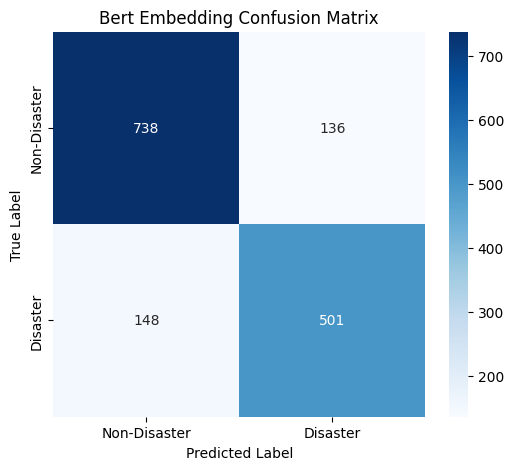

In [37]:
y_pred_thresh = (np.array(y_pred)  > 0.75).astype(int)
metrics = evaluate_model(y_test, y_pred_thresh, "Bert Embedding")

In [38]:
test = test.drop(['location', 'keyword'], axis=1)

test['clean_text'] = test['text'].apply(text_preprocess)

In [39]:
test

,id,text,clean_text
0,0,Just happened a terrible car crash,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, stay safe everyone.","Heard about earthquake is different cities, stay safe everyone."
2,3,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all","there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. Spokane wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
3259,10865,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power
3260,10868,Green Line derailment in Chicago http://t.co/UtbXLcBIuY,Green Line derailment in Chicago
3261,10874,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,MEG issues Hazardous Weather Outlook (HWO)


In [40]:
sample_submission['target'] = [predict(t) for t in test['clean_text']]

In [41]:
sample_submission['target']

0       0.999675
1       0.999312
2       0.999176
3       0.999728
4       0.999843
          ...   
3258    0.998990
3259    0.999795
3260    0.999858
3261    0.134527
3262    0.998858
Name: target, Length: 3263, dtype: float32

In [42]:
sample_submission['target'] = (np.array(sample_submission['target'])  > 0.75).astype(int)

In [43]:
sample_submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,0


In [44]:
sample_submission.to_csv("/kaggle/working/submission.csv", index=False)

In [45]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [46]:
download_file('/kaggle/working/submission.csv', 'out')

/kaggle/working/out.zip